# Description of the final project

## Introduction

In this project, you are going to work with the dataset based on the census data extracted from the 1994 and 1995 current population surveys conducted by the U.S. Census Bureau. Your goal is to predict level of income of a person: "- 50000" (means less than \$50k/year) or "50000+" (means more than \$50k/year). The data is split into train (`train.csv`) and test (`test.csv`) parts. You should use train part to train the models, and test part to estimate their final quality. The best quality on the test dataset should be your final result.

The description of the data is available here: https://archive.ics.uci.edu/ml/datasets/Census-Income+%28KDD%29

_Citation:_

* _Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science._

## Detailed Task Description

The solution should have the following parts:



### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text)
* Make sure that the instructor can run all the cells to reproduce your results
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques
* Support all your statements with calculations and plots. For instance, if you claim that the dataset does not have missing values, you need to provide the code which shows that the total number of missing values is zero

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_numeric(df, numeric_cols : list) -> None:
    """
    Plot numeric columns in a dataframe.
    """
    fig, axes = plt.subplots(3, 5, figsize=(25, 15))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col], ax=axes[i], kde=True)
        axes[i].set_title(col)

def plot_categorical(df, categorical_cols : list) -> None:
    """
    Plot categorical columns in a dataframe.
    """
    fig, axes = plt.subplots(7, 4, figsize=(40, 25))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        sns.countplot(x=col, data=df, ax=axes[i], orient='v')
        axes[i].set_title(col)

def evaluate_scores(model_name, y_test, preds, scores):
    """
    Evaluate model scores.
    """
    scores[f'{model_name}']['accuracy'] = accuracy_score(y_test, preds)
    scores[f'{model_name}']['precision'] = precision_score(y_test, preds)
    scores[f'{model_name}']['recall'] = recall_score(y_test, preds)
    scores[f'{model_name}']['f1'] = f1_score(y_test, preds)
    scores[f'{model_name}']['roc_auc'] = roc_auc_score(y_test, preds)
    return scores




In [3]:
train = pd.read_csv('census/census-income.data', header=None)
test = pd.read_csv('census/census-income.test', header=None)

In [4]:
cols = [
    'age',
    'worker_class',
    'detailed_industry_recode',
    'detailed_occupation_recode',
    'education',
    'wage_per_hour',
    'enroll_in_edu_inst_last_wk',
    'marital_status',
    'major_industry_code',
    'major_occupation_code',
    'race',
    'hispanic_origin',
    'sex',
    'labor_union_member',
    'unemployment_reason',
    'full_or_part_time_employment_stat',
    'capital_gains',
    'capital_losses',
    'dividends_from_stocks',
    'tax_filer_stat',
    'prev_residence_region',
    'prev_residence_state',
    'detailed_household_and_family_stat',
    'detailed_household_summary',
    'instance_weight',
    'migration_code_change_in_msa',
    'migration_code_change_in_reg',
    'migration_code_move_within_reg',
    'lives_in_house_1ya',
    'migration_prev_res_in_sunbelt',
    'num_persons_worked_for_employer',
    'family_members_under_18',
    'father_birth_country',
    'mother_birth_country',
    'self_birth_country',
    'citizenship',
    'own_business_or_self_employed',
    "fill_inc_questionnaire_for_veteran_admin",
    "veteran_benefits",
    'year_weeks_worked',
    'year',
    'target',
]

train.columns = cols
test.columns = cols

# dropping weight column, since it should not be used for classification problem due to the embeded info on the test set
train.drop('instance_weight', axis=1, inplace=True)
test.drop('instance_weight', axis=1, inplace=True)


# target map
target_map = {
    ' - 50000.': 0,
    ' 50000+.': 1
}

train['target'] = train['target'].map(target_map)
test['target'] = test['target'].map(target_map)

y_train = train['target']
y_test = test['target']

# drop targets from train  and test
train.drop('target', axis=1, inplace=True)
test.drop('target', axis=1, inplace=True)


# 1. Data exploration

`1.1 Which metric are you going to use to evaluate the performance of the model and why?`
At first, I thought about using F1 metric, since it is more stable than simple accuracy or precision. F1 score resembles a weighted average of the precision and recall; F1 score reaches its best value at 1 and worst score at 0. I'll set relative contribution of precision and recall to the F1 score to be equal. The formula for the F1 score is:

$$F1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$$

On a second thought, however, I decided to go with precision. Given that smaller positive class is only 6%, it is reasonable to base our score metric around precision. This makes sense to the extent that underestimation (namely, missclassifying a true positive) is potentially more harmful. Census data can be utilized as some sort of a proxy for economic growth, and underestimation becomes more problematic. Overestimation, on the other hand, is less likely to have adverse effects. After all, if I say you will earn less than 50k$, and you actually start earning more - no-one is worse off in that scenario.

I'll use the implementations of the the score metrics from the `sklearn.metrics` module.

In [5]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

`1.2. Which validation strategy are you going to use and why? Apply it to the data on the preprocessing step`

To asnwer this question, let us check the distribution of the target variable in the train and test datasets. If the distribution is heavily skewed, we should use stratified sampling to preserve the ratio of the target classes in the train and test datasets. Otherwise, we can use simple random sampling.

Let us check the distribution of the target variable in the train and test datasets.


In [6]:
y_train.value_counts(normalize=True)

target
0    0.937942
1    0.062058
Name: proportion, dtype: float64

$\implies$ the distribution of the target variable in the train dataset is heavily skewed $\therefore$ stratified sampling should be used to preserve the ratio of the target classes in the train and test datasets.

`1.3 Explore which features do you have, what is their distribution and connection to the target. Perform feature selection techniques such as PCA, and feature engineering, if necessary. Explain your decisions`

Let us explore the numeric features first.


In [7]:
# checking numeric columns
numeric_cols = [col for col in train.columns if train[col].dtype != 'object']
# numeric_cols.remove('target')
print(f"Number of numeric cols: {len(numeric_cols)}\nNumeric columns: {numeric_cols}\n")

# check zero-variance columns
print(train[numeric_cols].var())

# checking info of numeric columns
train.describe()

Number of numeric cols: 12
Numeric columns: ['age', 'detailed_industry_recode', 'detailed_occupation_recode', 'wage_per_hour', 'capital_gains', 'capital_losses', 'dividends_from_stocks', 'num_persons_worked_for_employer', 'own_business_or_self_employed', 'veteran_benefits', 'year_weeks_worked', 'year']

age                                4.977760e+02
detailed_industry_recode           3.264211e+02
detailed_occupation_recode         2.089240e+02
wage_per_hour                      7.556806e+04
capital_gains                      2.206680e+07
capital_losses                     7.392767e+04
dividends_from_stocks              3.936905e+06
num_persons_worked_for_employer    5.593819e+00
own_business_or_self_employed      3.065775e-01
veteran_benefits                   7.250070e-01
year_weeks_worked                  5.959208e+02
year                               2.500011e-01
dtype: float64


,age,detailed_industry_recode,detailed_occupation_recode,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,num_persons_worked_for_employer,own_business_or_self_employed,veteran_benefits,year_weeks_worked,year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,6.000000,2.000000,2.000000,52.000000,95.000000


Some of the numeric columns have a lot of zeros. Let's check the distribution of these columns.

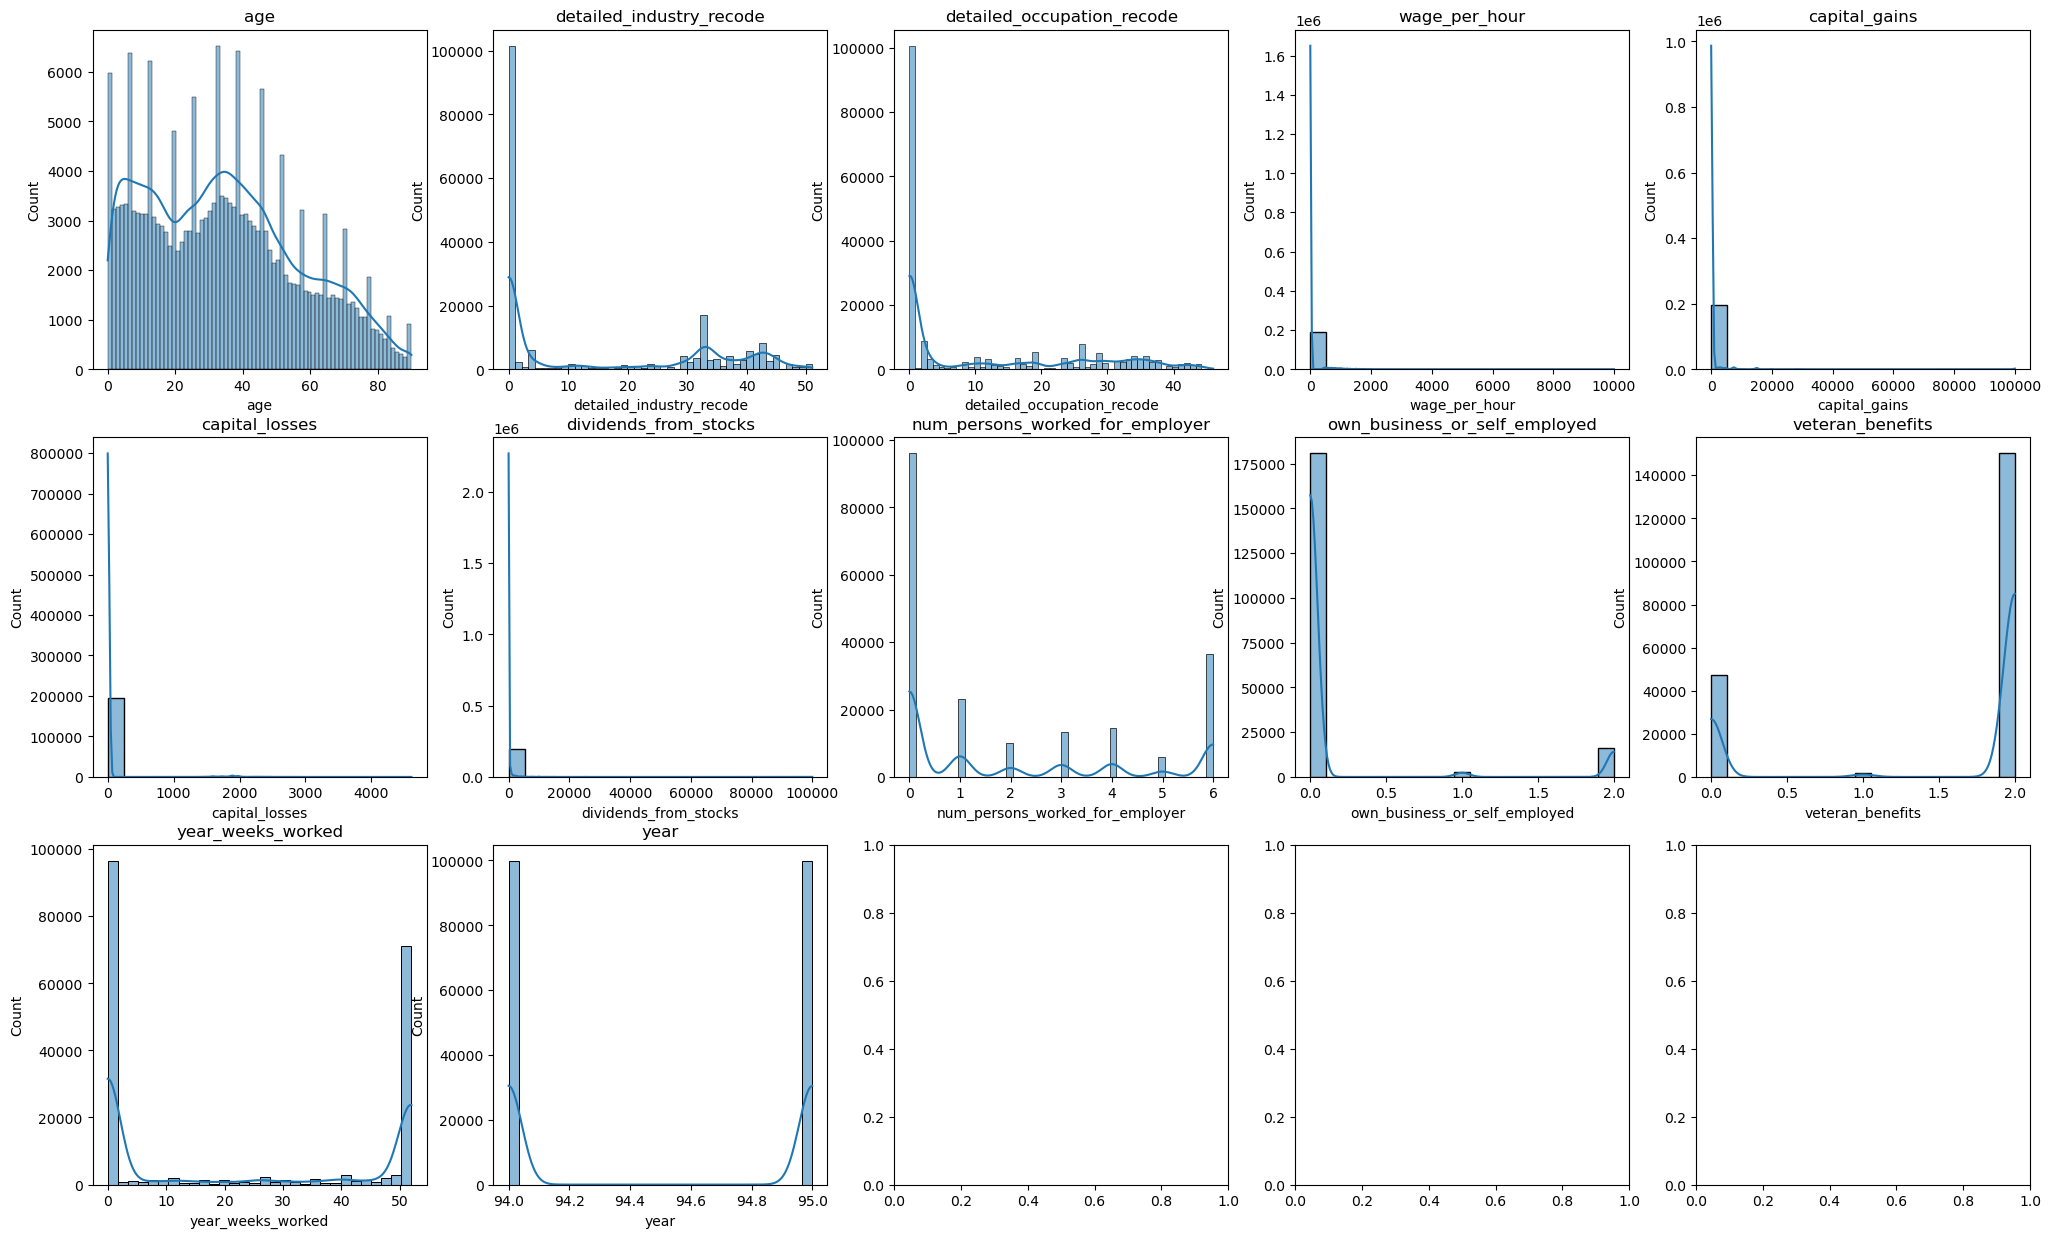

In [8]:
# check distributions
plot_numeric(train, numeric_cols)

Given the result above, we can drop all columns with more than 25% of zeros. They will skew the data and are arbitrarily less informative for the model. 

In [9]:
zero_cols = []

for col in numeric_cols:
    if train[col].value_counts(normalize=True).values[0] > 0.9:
        zero_cols.append(col)

print(f"Number of zero-value cols: {len(zero_cols)}\nZero-value columns: {zero_cols}\n")

Number of zero-value cols: 4
Zero-value columns: ['wage_per_hour', 'capital_gains', 'capital_losses', 'own_business_or_self_employed']




Now, let's proceed with categorical columns.

In [10]:
# checking binary columns
bin_cols = [col for col in train.columns if train[col].dtype == 'object' and train[col].nunique() == 2]
print(f"Number of binary cols: {len(bin_cols)}\nCategorical columns: {bin_cols}")

# checking categorical columns
cat_cols = [col for col in train.columns if train[col].dtype == 'object']
print(f"Number of categorical cols: {len(cat_cols)}\nCategorical columns: {cat_cols}")

Number of binary cols: 1
Categorical columns: ['sex']
Number of categorical cols: 28
Categorical columns: ['worker_class', 'education', 'enroll_in_edu_inst_last_wk', 'marital_status', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'labor_union_member', 'unemployment_reason', 'full_or_part_time_employment_stat', 'tax_filer_stat', 'prev_residence_region', 'prev_residence_state', 'detailed_household_and_family_stat', 'detailed_household_summary', 'migration_code_change_in_msa', 'migration_code_change_in_reg', 'migration_code_move_within_reg', 'lives_in_house_1ya', 'migration_prev_res_in_sunbelt', 'family_members_under_18', 'father_birth_country', 'mother_birth_country', 'self_birth_country', 'citizenship', 'fill_inc_questionnaire_for_veteran_admin']


In [11]:
# Let us also check for cardinality before we proceed with encoding
train[cat_cols].nunique().sort_values(ascending=False).head(10)

prev_residence_state                  51
self_birth_country                    43
mother_birth_country                  43
father_birth_country                  43
detailed_household_and_family_stat    38
major_industry_code                   24
education                             17
major_occupation_code                 15
hispanic_origin                       10
migration_code_move_within_reg        10
dtype: int64

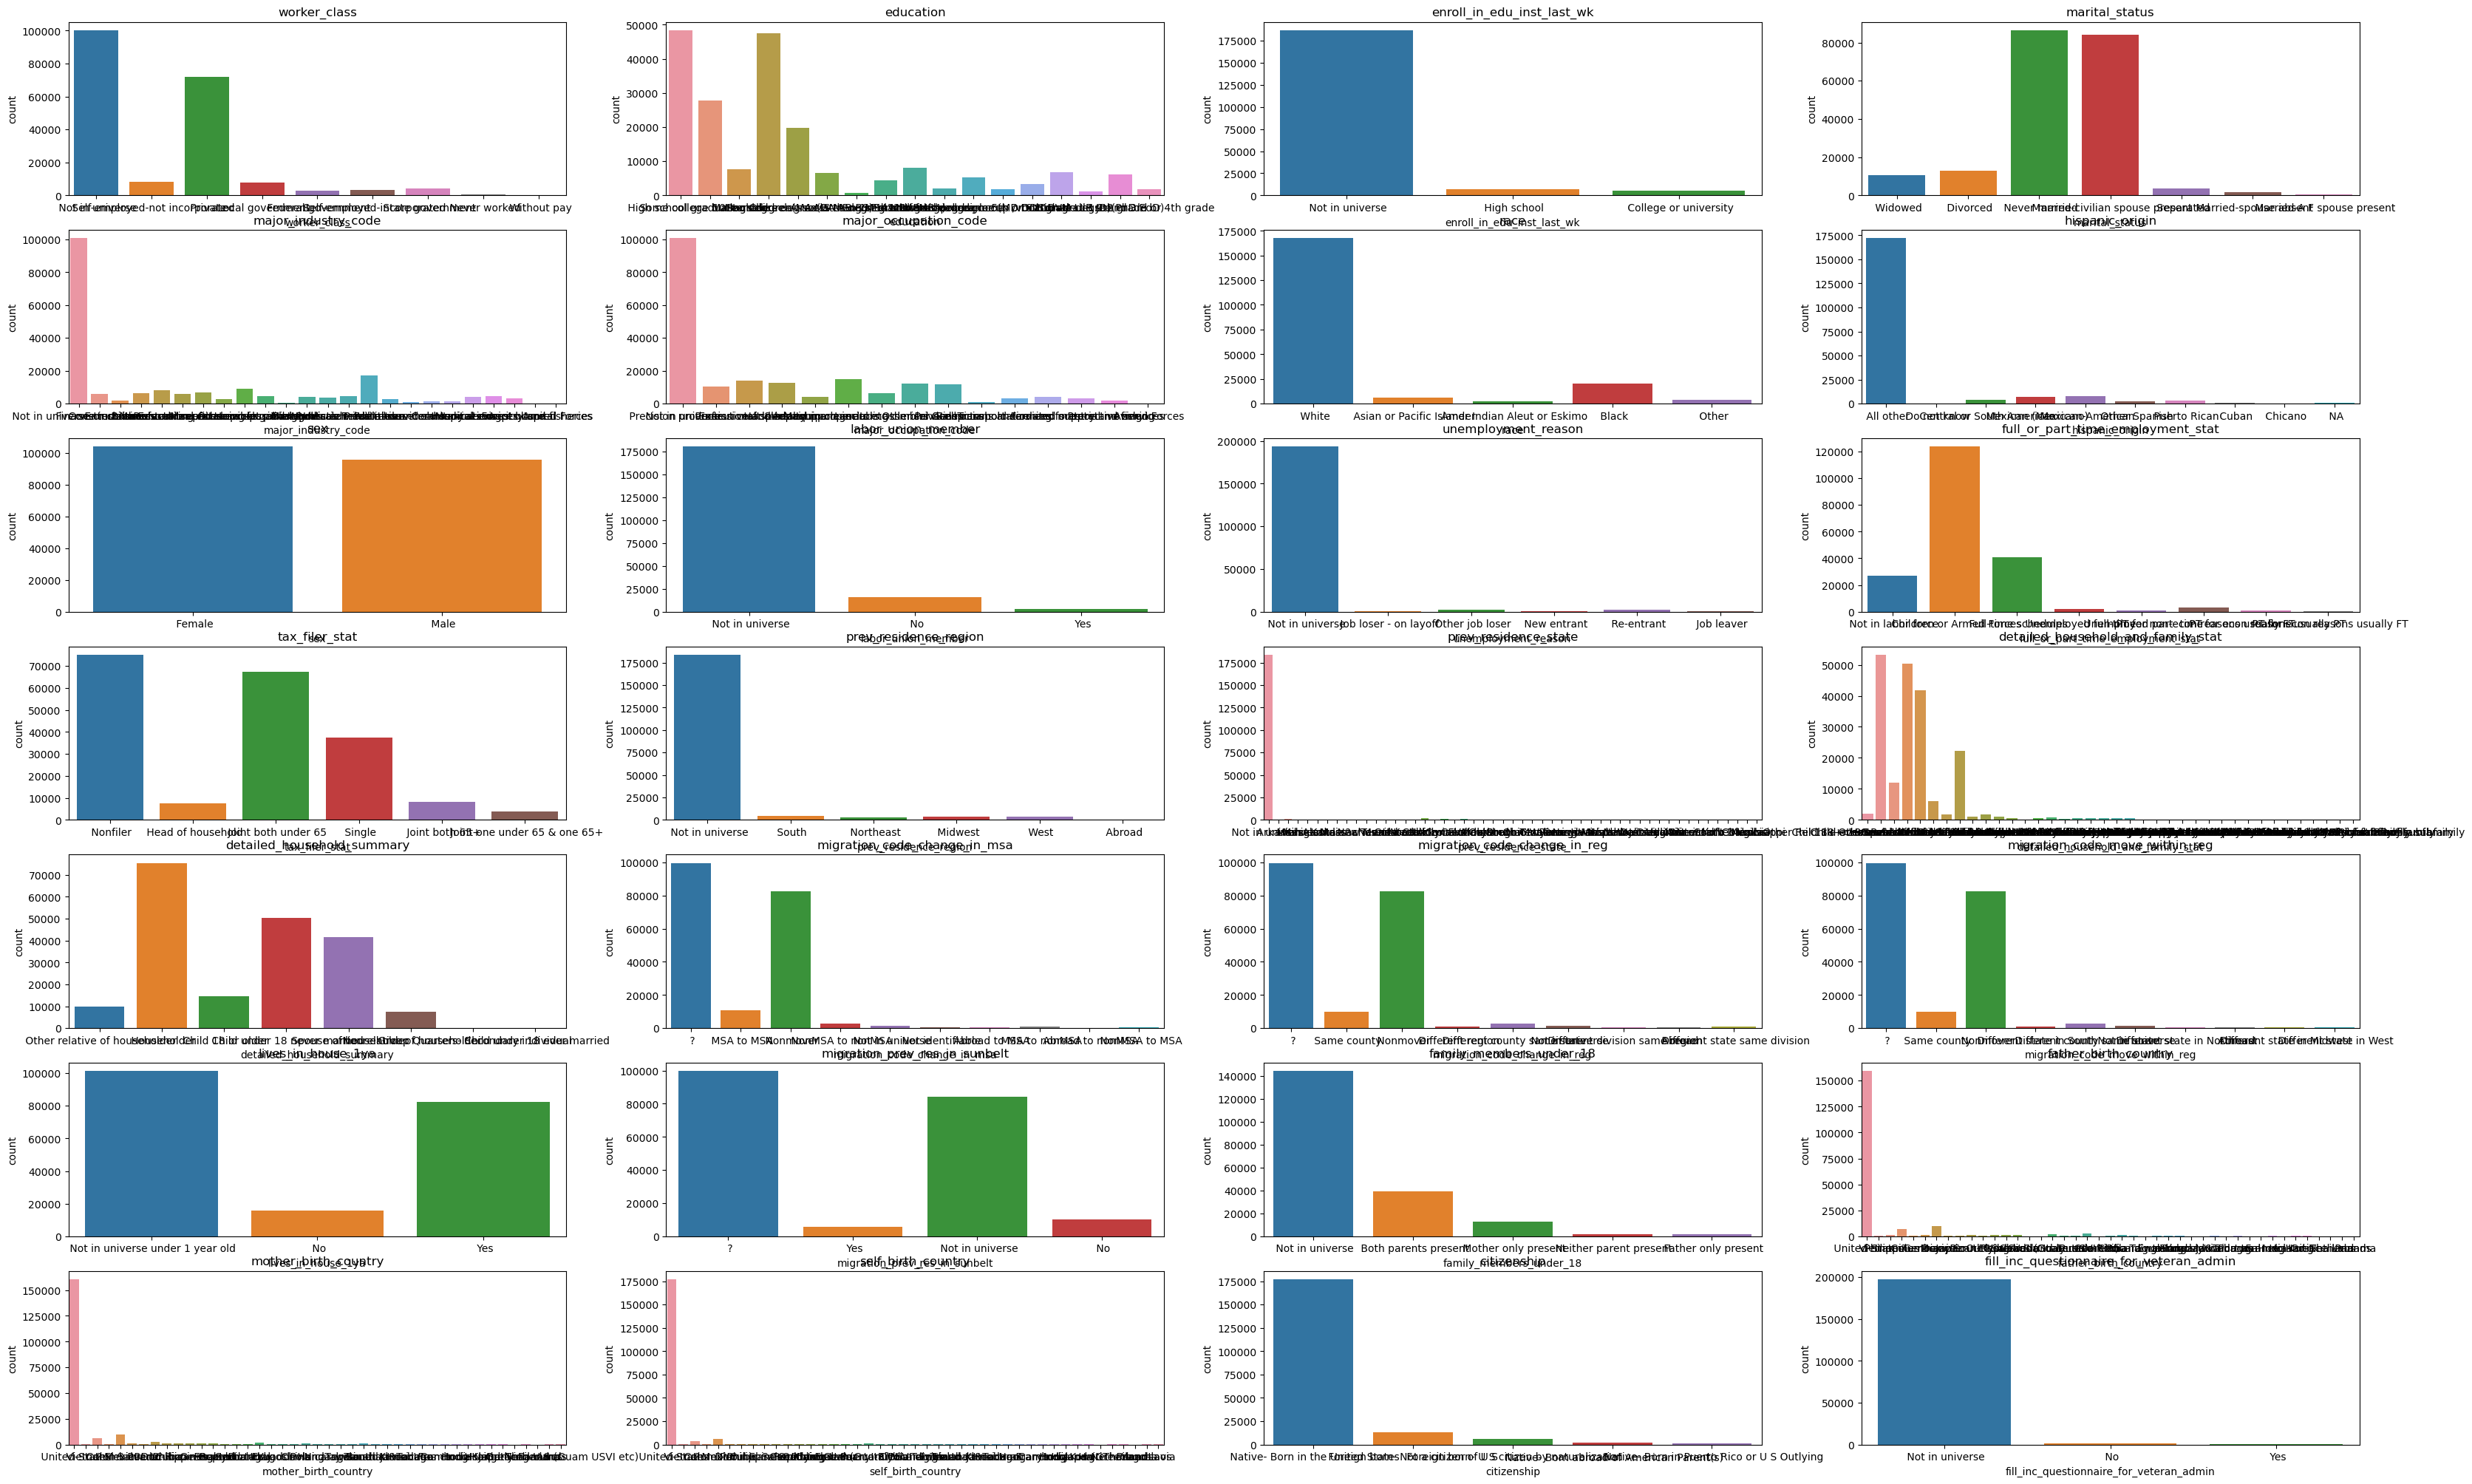

In [12]:
plot_categorical(train, cat_cols)


# Data preprocessing


2.1. Fill missing values (if there are any)


In [13]:
assert train.isna().sum().sum() == 0
assert test.isna().sum().sum() == 0

we don't have any missing values in the data encoded as NaNs, but we have missing values encoded as '?'

In [14]:
train.replace(' ?', np.nan, inplace=True)

# check missing values percentage
missing_value_cols = train.columns[train.isna().any()].tolist()
threshold = 0.3
missing_value_cols = [col for col in missing_value_cols if train[col].isna().mean() > threshold]
print(f"Number of missing value cols: {len(missing_value_cols)}\nMissing value cols: {missing_value_cols}")

# proportion of missing values
train[missing_value_cols].isna().mean().sort_values(ascending=False)

Number of missing value cols: 4
Missing value cols: ['migration_code_change_in_msa', 'migration_code_change_in_reg', 'migration_code_move_within_reg', 'migration_prev_res_in_sunbelt']


migration_code_change_in_msa      0.499672
migration_code_change_in_reg      0.499672
migration_code_move_within_reg    0.499672
migration_prev_res_in_sunbelt     0.499672
dtype: float64

2.2. Properly encode categorical features. Explain your choice of methods of categorical feature encoding

Given that we have many binary features, we can use LabelEncoder to encode them. This approach is better than OneHotEncoder, since we will not end up with many columns. We will use OneHotEncoder for the remaining categorical features since the cardinality is not too high.

Given our EDA above, we can see that only 'sex' column is binary. We will use LabelEncoder to encode this column.

For the rest of the categorical columns, we will use OneHotEncoder to encode them if the cardinality is less than 10. Otherwise, we will use TargetEncoder.

In [15]:
# label encoding for binary column
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in bin_cols:
        train[col] = le.fit_transform(train[col])
        test[col] = le.transform(test[col])


For categorical columns with more than 2<n<10 categories, we will use one-hot encoding. Otherwise, we will use target encoding.

In [16]:
from sklearn.preprocessing import TargetEncoder


cat_cols = [col for col in train.columns if train[col].dtype == 'object']

print(f"Number of categorical cols: {len(cat_cols)}\nCategorical columns: {cat_cols}\n")

train[cat_cols].nunique().sort_values(ascending=False).head(10)

threshold_vals = 10
high_cardinality_cols, low_cardinality_cols = [col for col in cat_cols if train[col].nunique() > threshold_vals],  [col for col in cat_cols if train[col].nunique() <= threshold_vals]
print(f"Number of high cardinality cols: {len(high_cardinality_cols)}\nHigh cardinality cols: {high_cardinality_cols}\n")
print(f"Number of low cardinality cols: {len(low_cardinality_cols)}\nLow cardinality cols: {low_cardinality_cols}")


Number of categorical cols: 27
Categorical columns: ['worker_class', 'education', 'enroll_in_edu_inst_last_wk', 'marital_status', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'labor_union_member', 'unemployment_reason', 'full_or_part_time_employment_stat', 'tax_filer_stat', 'prev_residence_region', 'prev_residence_state', 'detailed_household_and_family_stat', 'detailed_household_summary', 'migration_code_change_in_msa', 'migration_code_change_in_reg', 'migration_code_move_within_reg', 'lives_in_house_1ya', 'migration_prev_res_in_sunbelt', 'family_members_under_18', 'father_birth_country', 'mother_birth_country', 'self_birth_country', 'citizenship', 'fill_inc_questionnaire_for_veteran_admin']

Number of high cardinality cols: 8
High cardinality cols: ['education', 'major_industry_code', 'major_occupation_code', 'prev_residence_state', 'detailed_household_and_family_stat', 'father_birth_country', 'mother_birth_country', 'self_birth_country']

Number of low c

In [17]:
# te for high cardinality cols
from category_encoders import TargetEncoder

te = TargetEncoder(cols=high_cardinality_cols)

te.fit(train, y_train)

train_enc = te.transform(train)
test_enc = te.transform(test)

In [18]:
# ohe for low cardinality cols
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

train_enc = ohe.fit_transform(train[low_cardinality_cols])
test_enc = ohe.transform(test[low_cardinality_cols])

train_enc = pd.DataFrame(train_enc, columns=ohe.get_feature_names_out())
test_enc = pd.DataFrame(test_enc, columns=ohe.get_feature_names_out())

a:\rustya\Anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
# scale numeric cols
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_enc = scaler.fit_transform(train[numeric_cols])
test_enc = scaler.transform(test[numeric_cols])

train_enc = pd.DataFrame(train_enc, columns=numeric_cols)
test_enc = pd.DataFrame(test_enc, columns=numeric_cols)



* 2.3. (8%) Cluster observations and add cluster number as one of the features. Make sure that the clustering method has a good quality


Let us use the elbow method to find the optimal number of clusters. We will use the PCA components for this.


a:\rustya\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
a:\rustya\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
a:\rustya\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
a:\rustya\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly

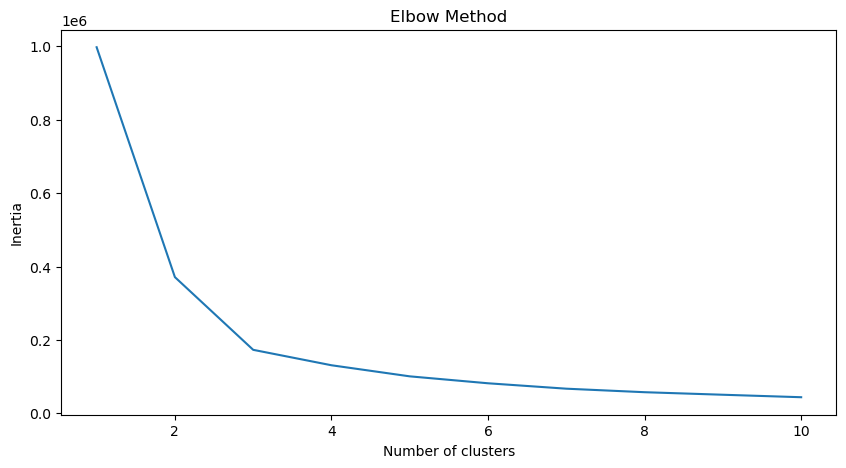

In [20]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[numeric_cols])

pca = PCA(n_components=2)
pca.fit(train_scaled)
train_pca = pca.transform(train_scaled)

inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(train_pca)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


Given that we used elbow method on the numeric columns only, it may be a good idea to try to find most useful features using Random forest classifier.

In [21]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=1234)
train['cluster'] = kmeans.fit_predict(train[numeric_cols])
test['cluster'] = kmeans.predict(test[numeric_cols])

a:\rustya\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of components: 9
Explained variance: 0.94


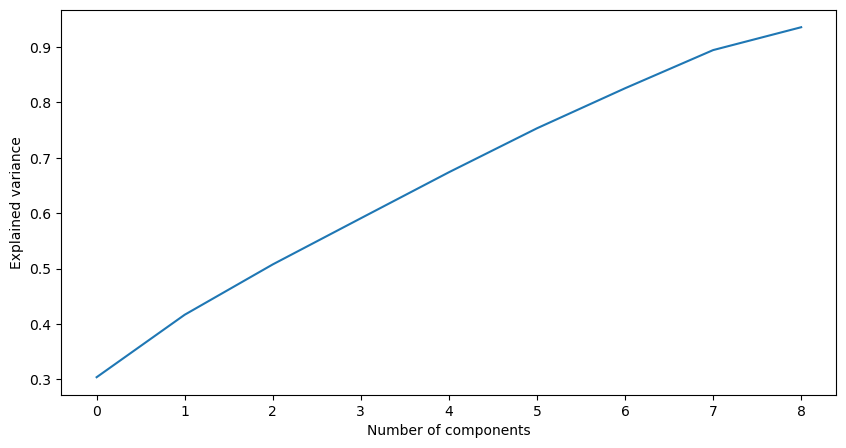

In [22]:
pca = PCA(n_components=0.9)
pca.fit(train_enc)
train_pca = pca.transform(train_enc)
test_pca = pca.transform(test_enc)

print(f"Number of components: {pca.n_components_}\nExplained variance: {round(pca.explained_variance_ratio_.sum(), 2)}")

# plot explained variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()


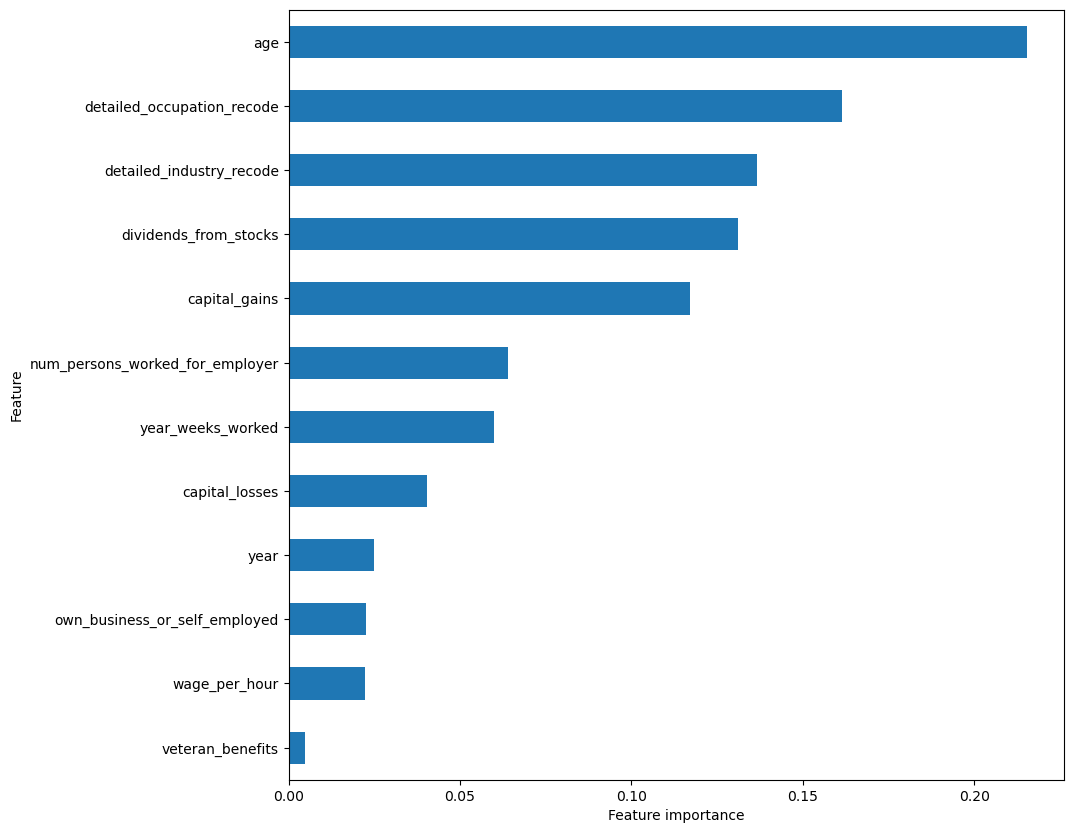

In [23]:
# use random forest classifier to select features
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=1234, n_jobs=-1)
rf.fit(train_enc, y_train)


# plot feature importance in asc order
plt.figure(figsize=(10, 10))
feat_imp = pd.Series(rf.feature_importances_, index=train_enc.columns).sort_values(ascending=True)
feat_imp.plot(kind='barh')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()




### [25%] 3. Model training

* 3.1. (8%) Apply different techniques which can help to work with imbalanced data. You are supposed to try at least 2 techniques (in the end, you don't have to include them into your final pipeline - but you should explain why)
* 3.2. (9%) Train different machine learning models, including the advanced boosting algorithms studied during the course. Carefully tune hyperparameters of the algorithms. You are supposed to compare at least 3 models
* 3.3. (8%) Perform blending or stacking of the trained machine learning algorithms. Carefully tune the weights of the ensemble


I will use the following models for this project:
- Logistic Regression
- LightGBM
- XGBoost
- Random Forest

Lastly, I'll use an ensemble of all four models.

These models will be evaluated using the following metrics:
- Accuracy (quite redundant in our case, but still is a proxy / fail-safe)
- Precision
- Recall
- F1
- ROC AUC

In [24]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

scores = {'lgbm' : {},
          'xgb' : {},
          'rf' : {},
          'logreg' : {},
          'ensemble' : {}
          }



In [25]:
# let us run a light gradient boosting model on the data, with 5-fold cross validation
from sklearn.metrics import make_scorer, recall_score, precision_score, roc_auc_score

import lightgbm as lgb

model_name = 'lgbm'

model = lgb.LGBMClassifier(random_state=1234, n_jobs=-1, n_estimators=1000, max_depth=10, learning_rate=0.05) 
model.fit(train_enc, y_train)
preds = model.predict(test_enc)

evaluate_scores(model_name, y_test, preds, scores)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 12382, number of negative: 187141
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1001
[LightGBM] [Info] Number of data points in the train set: 199523, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062058 -> initscore=-2.715619
[LightGBM] [Info] Start training from score -2.715619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

{'lgbm': {'accuracy': 0.9556143621819931,
  'precision': 0.7567172897196262,
  'recall': 0.4188490139023602,
  'f1': 0.5392299687825183,
  'roc_auc': 0.7049735793629096},
 'xgb': {},
 'rf': {},
 'logreg': {},
 'ensemble': {}}

In [26]:
import xgboost as xgb

model_name = 'xgb'

# init model
model = xgb.XGBClassifier(random_state=1234, n_jobs=-1, n_estimators=1000, max_depth=10, learning_rate=0.05)
model.fit(train_enc, y_train)
preds = model.predict(test_enc)

evaluate_scores(model_name, y_test, preds, scores)



{'lgbm': {'accuracy': 0.9556143621819931,
  'precision': 0.7567172897196262,
  'recall': 0.4188490139023602,
  'f1': 0.5392299687825183,
  'roc_auc': 0.7049735793629096},
 'xgb': {'accuracy': 0.9549728353481286,
  'precision': 0.7371220604703248,
  'recall': 0.42563853863562884,
  'f1': 0.5396597663455626,
  'roc_auc': 0.7078019571864986},
 'rf': {},
 'logreg': {},
 'ensemble': {}}

In [27]:
from sklearn.ensemble import RandomForestClassifier

model_name = 'rf'
model = RandomForestClassifier(random_state=1234, n_jobs=-1, n_estimators=1000, max_depth=10)
model.fit(train_enc, y_train)
preds = model.predict(test_enc)

evaluate_scores(model_name, y_test, preds, scores)

{'lgbm': {'accuracy': 0.9556143621819931,
  'precision': 0.7567172897196262,
  'recall': 0.4188490139023602,
  'f1': 0.5392299687825183,
  'roc_auc': 0.7049735793629096},
 'xgb': {'accuracy': 0.9549728353481286,
  'precision': 0.7371220604703248,
  'recall': 0.42563853863562884,
  'f1': 0.5396597663455626,
  'roc_auc': 0.7078019571864986},
 'rf': {'accuracy': 0.9505222429381929,
  'precision': 0.8039883268482491,
  'recall': 0.2672162948593598,
  'f1': 0.40111623392380497,
  'roc_auc': 0.6314548175160268},
 'logreg': {},
 'ensemble': {}}

In [28]:
from sklearn.linear_model import LogisticRegression

model_name = 'logreg'

# init model
model = LogisticRegression(random_state=1234, n_jobs=-1, max_iter=1000)
model.fit(train_enc, y_train)
preds = model.predict(test_enc)

evaluate_scores(model_name, y_test, preds, scores)

{'lgbm': {'accuracy': 0.9556143621819931,
  'precision': 0.7567172897196262,
  'recall': 0.4188490139023602,
  'f1': 0.5392299687825183,
  'roc_auc': 0.7049735793629096},
 'xgb': {'accuracy': 0.9549728353481286,
  'precision': 0.7371220604703248,
  'recall': 0.42563853863562884,
  'f1': 0.5396597663455626,
  'roc_auc': 0.7078019571864986},
 'rf': {'accuracy': 0.9505222429381929,
  'precision': 0.8039883268482491,
  'recall': 0.2672162948593598,
  'f1': 0.40111623392380497,
  'roc_auc': 0.6314548175160268},
 'logreg': {'accuracy': 0.945901244963012,
  'precision': 0.736936936936937,
  'recall': 0.19835111542192047,
  'f1': 0.3125716469239588,
  'roc_auc': 0.5968352140330941},
 'ensemble': {}}

Lastly, lets try an ensemble of the above models. We will use a simple majority voting scheme to predict the final class. We will use the same models as above, but with different random seeds.

In [29]:
from sklearn.ensemble import VotingClassifier

model_name = 'ensemble'


model = VotingClassifier(estimators=[('lgbm', lgb.LGBMClassifier(random_state=13, n_jobs=-1, n_estimators=1000, max_depth=10, learning_rate=0.05)),
                                     ('xgb', xgb.XGBClassifier(random_state=13, n_jobs=-1, n_estimators=1000, max_depth=10, learning_rate=0.05)),
                                     ('rf', RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=1000, max_depth=10)),
                                     ('logreg', LogisticRegression(random_state=13, n_jobs=-1, max_iter=1000))],
                                     voting='hard', n_jobs=-1)
model.fit(train_enc, y_train)
preds = model.predict(test_enc)

# evaluate scores
evaluate_scores(model_name, y_test, preds, scores)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


{'lgbm': {'accuracy': 0.9556143621819931,
  'precision': 0.7567172897196262,
  'recall': 0.4188490139023602,
  'f1': 0.5392299687825183,
  'roc_auc': 0.7049735793629096},
 'xgb': {'accuracy': 0.9549728353481286,
  'precision': 0.7371220604703248,
  'recall': 0.42563853863562884,
  'f1': 0.5396597663455626,
  'roc_auc': 0.7078019571864986},
 'rf': {'accuracy': 0.9505222429381929,
  'precision': 0.8039883268482491,
  'recall': 0.2672162948593598,
  'f1': 0.40111623392380497,
  'roc_auc': 0.6314548175160268},
 'logreg': {'accuracy': 0.945901244963012,
  'precision': 0.736936936936937,
  'recall': 0.19835111542192047,
  'f1': 0.3125716469239588,
  'roc_auc': 0.5968352140330941},
 'ensemble': {'accuracy': 0.9514043423347567,
  'precision': 0.8392494929006086,
  'recall': 0.2675396055609441,
  'f1': 0.40573670017161073,
  'roc_auc': 0.6320759924017425}}


### [25%] 4. Summary

* 4.1. (8%) Estimate the quality of the models and their ensemble on the test set. Describe the results. Which model is the best?
* 4.2. (8%) Interpret the best single model and the ensemble. Use at least 2 model interpretation techniques. Explain, why your models have good quality (or bad quality)
* 4.3. (9%) Summarize your results and write a conclusion. What have you found in the data, which techniques did you use? Which methods and models worked best in your task? Can you explain in simple words why should we trust your final model?


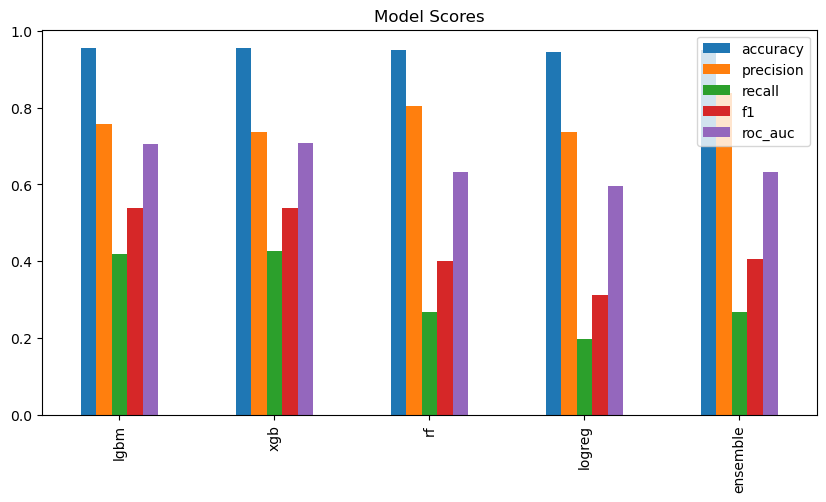

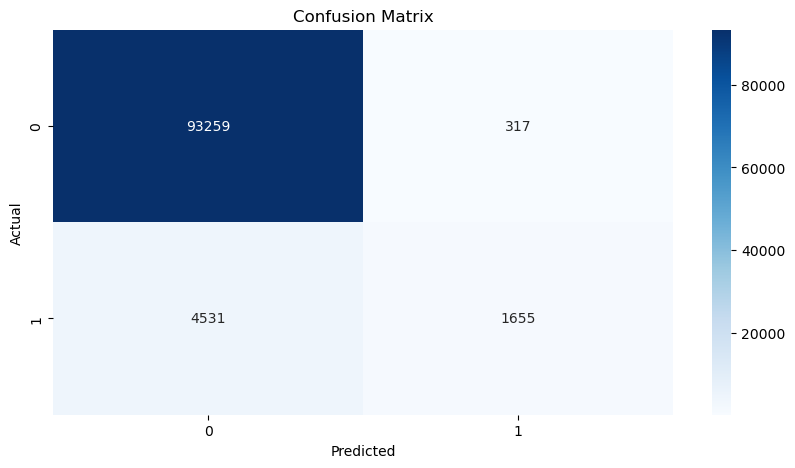

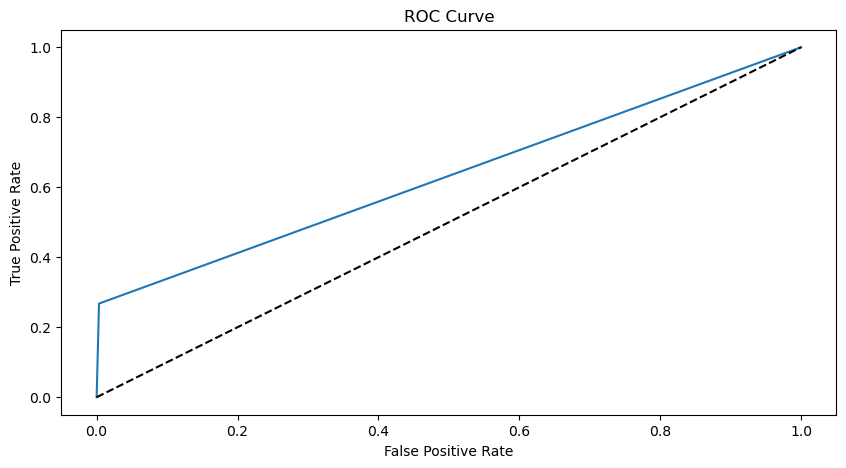

In [30]:
# scores to df
scores_df = pd.DataFrame(scores).T

scores_df.plot(kind='bar', figsize=(10, 5))
plt.title('Model Scores')

plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.figure(figsize=(10, 5))
fpr, tpr, thresholds = roc_curve(y_test, preds)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()



In [31]:
scores_df

,accuracy,precision,recall,f1,roc_auc
lgbm,0.955614,0.756717,0.418849,0.539230,0.704974
xgb,0.954973,0.737122,0.425639,0.539660,0.707802
rf,0.950522,0.803988,0.267216,0.401116,0.631455
logreg,0.945901,0.736937,0.198351,0.312572,0.596835
ensemble,0.951404,0.839249,0.267540,0.405737,0.632076



- **LightGBM** model has the highest accuracy, indicating it correctly classifies a higher percentage of instances than the other models. However, its recall is not the highest, which means it misses a significant number of positive instances.

- **XGBoost** has slightly lower accuracy than LightGBM, but it has the highest recall, meaning it is better at identifying positive instances. It also has the highest ROC AUC score, indicating it is the best model in terms of distinguishing between classes.

- **Random Forest** has the highest precision, meaning it has a lower rate of false positives. However, it has the lowest recall, indicating it misses a large number of positive instances. Its ROC AUC score is also lower than LightGBM and XGBoost.

- **Logistic Regression (logreg)** has the lowest accuracy, precision, recall, F1 score, and ROC AUC score, indicating it performs worse than the other models in all aspects. This is most likely due to absence of proper tuning.

- **Ensemble** of all these models looks best precision-wise, but lacks in other aspects. The grid search over params may fix this situation.


So, overall if our priority is to minimize false positives, the *Random Forest model* suffice since it has high precision. If the goal is to maximize correct classification of positive instances, *XGBoost* would be the best choice due to its high recall. Algthough, I'd like to note that judging overall XGBoost seems to provide the best balance

Insights and thoughts:
- The data is heavily imbalanced, so formulating your evaluation metric becomes crucial to address this imbalance.
- Despite the size of the dataset, we do not have that many meaningful data. PCA shows that 9 features explain more than 90% of data variability.
- Choosing between different classification models yields a classical precision-recall trade-off. Despite that, some models look much more robust and balanced.
- I didn't use either undersampling or oversampling because they are mostly useless in any real-world scenario. Having many stratas and features makes oversampling redundant because you won't properly simulate the real world data. Moreover, as Random Forest algo showed, the relative importance of most features is 1) insignificant, and 2) most significant features may actually be outside of the dataset.

Techniques used:
- OHE, target encoding, label encoding were used for data cleaning. During EDA I've found many instances when columns could be dropped due to either very low cardinality or too many artificially missing values or zero values. 

Models used:
- LGBM, XGB, RF, LR
- ensemble of the above